In [100]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import jax.random as jr
import koopcore
import os, datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import tqdm
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
jax.config.update("jax_enable_x64", True)

In [102]:
STEPS = 15
DT = 1/ STEPS
N_TRAIN = 50
N_TEST = 50
D = 100
DEVICES = jax.devices("gpu")
LOAD_DATA = 0 
N_RUNS = 24

PRNGKey = jr.PRNGKey(44)
params_base_kernel = {"name": "square-exponential", "p_kernel":{"scale":0.05}}
save_path = os.path.join("results", "bi-stable"+"_" +datetime.datetime.today().strftime('%Y-%m-%d'))

In [103]:
def generate_data(N, STEPS, PRNGKey):
    dynamical_system = koopcore.auxilliary.make_1d_ct_cubic_bernoulli(*koopcore.auxilliary.params_ct_cubic_bernoulli_ubox)
    initial_conditions = koopcore.auxilliary.sample_box(N, PRNGKey=PRNGKey)[0][:,0].reshape(-1, 1)
    return koopcore.auxilliary.get_gamma_ivp(STEPS, initial_conditions, dynamical_system, DT)
def generate_eigenvalues_dt(D, PRNGKey=jax.random.PRNGKey(0)):
    return koopcore.auxilliary.convert_2d_to_complex(koopcore.auxilliary.sample_disk(D, random=True, PRNGKey=PRNGKey)[0])

In [104]:
os.makedirs(save_path, exist_ok=True)

if LOAD_DATA:
    data_load = koopcore.auxilliary.load_trajectory_dict(os.path.join(save_path, "data.npz"))
    data_train = data_load["train"]
    data_test = data_load["test"]
else:
    PRNGKey, subkey = jr.split(PRNGKey)
    data = generate_data(N_TRAIN + N_TEST, STEPS, subkey)
    data_train = data.select_N([i for i in range(N_TRAIN)])
    data_test = data.select_N([i for i in range(N_TRAIN, N_TRAIN+N_TEST)])
    koopcore.auxilliary.save_trajectory_dict(os.path.join(save_path, "data"), train=data_train, test=data_test)

In [105]:
def preprocess_data(data_train, data_test):
    preprocessor = {"x": MinMaxScaler((-1, 1)), "y": MinMaxScaler((-1, 1))}
    preprocessor["x"].fit(data_train["x"][:, 0, :])
    preprocessor["y"].fit(data_train["y"][:, 0, :])
    for d in [data_train, data_test]:
        for i in ["x", "y"]:
            d[i].set_X(preprocessor[i].transform(d[i].X.reshape(-1, d[i].d)).reshape(-1, d[i].H, d[i].d) )
    return preprocessor, data_train, data_test
def postprocess_data(data, preprocessor):
    for i in ["x", "y"]:
        data[i].X  = preprocessor[i].transform(data[i].X.reshape(-1, data[i].d)).reshape(-1, data[i].H, data[i].d)
    return  data

In [106]:
def square_error(x):
        return  jnp.sum(jnp.abs(x)**2) / x.shape[0]
def fit_KKR_model(data_train, data_test, eigenvalues, lengthscale, result, run, device):
    KKR_model = koopcore.model.kkr_estimator.KoopmanKernelDTRegressor(
        eigenvalues=eigenvalues,
        preprocessor=MinMaxScaler((-1., 1)),
        kernel_name=params_base_kernel["name"],
        kernel_params={"scale": lengthscale},
        timestep=DT,
        device=device,
        regularizer_invariant=1e-8,
        regularizer_isometric=1e-8
    )
    steps = data_train["y"].H-1
    KKR_model.fit(data_train["x"], data_train["y"])
    prediction_train = KKR_model.predict(data_train["x"][:, 0, :],steps)
    prediction_test = KKR_model.predict(data_test["x"][:, 0, :], steps)
    residual_train = data_train["y"]-prediction_train
    residual_test = data_test["y"]-prediction_test
    os.makedirs(os.path.join(save_path, "models"), exist_ok=True)
    KKR_model.save(os.path.join(save_path, "models", f"KKR_model_{run}.pkl"))

    L2_errors_train = koopcore.auxilliary.p_norm((residual_train).X, [0, 1, 2], 2)
    L2_errors_test = koopcore.auxilliary.p_norm((residual_test).X, [0, 1, 2], 2)
    square_error_train = square_error((residual_train).X)
    square_error_test = square_error((residual_test).X)
    result[str(run)] = {"lengthscale": lengthscale, "L2_errors_train": L2_errors_train, "L2_errors_test": L2_errors_test, "steps": steps, 
                        "square_error_train":square_error_train, "square_error_test":square_error_test, 
                        "data_test": data_test, "data_train": data_train, "prediction_test": prediction_test, "prediction_train": prediction_train}
    return result


def experiment(rng, STEPS, result, run, device):
    rng, subkey = jr.split(rng)
    data = generate_data(N_TRAIN + N_TEST, STEPS, subkey)
    data_train = data.select_N([i for i in range(N_TRAIN)])
    data_test = data.select_N([i for i in range(N_TRAIN, N_TRAIN+N_TEST)])
    data_train = {"x":data_train, "y":data_train}
    data_test = {"x":data_test, "y":data_test}
    rng, subkey = jr.split(rng)
    eigenvalues = generate_eigenvalues_dt(D, subkey)
    preprocessor = preprocess_data(data_train, data_test)
    result = fit_KKR_model(data_train, data_test,
                           eigenvalues, params_base_kernel["p_kernel"]["scale"], result, run, device)
    return result, preprocessor

## Setup tasks

In [107]:
PRNGKey, subkey = jr.split(PRNGKey)
variation_rng = rng_runs = jr.split(subkey, N_RUNS)
variation_steps = [i+1 for i in range(STEPS)]
tasks =list(product(variation_rng, variation_steps))


## Run experiments

In [108]:
logger = tqdm.tqdm_notebook(total = len(tasks))
log = lambda x: logger.update(x)
workers = koopcore.auxilliary.multithreading.tmap(experiment, DEVICES, log=log)
results = workers(tasks)

## Postprocess data


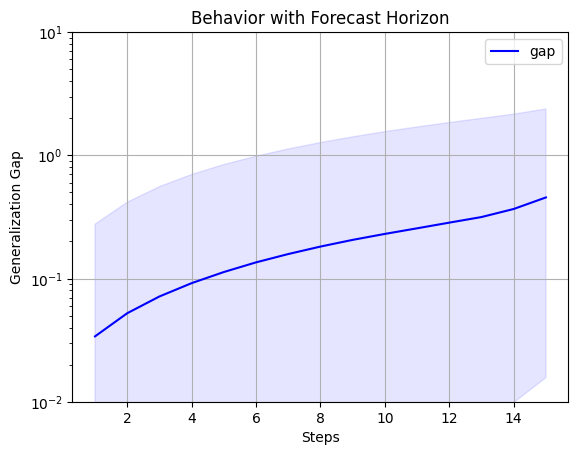

In [112]:
results_arr = jnp.array([(float(results[k]["steps"]), float(results[k]["square_error_train"]), float(results[k]["square_error_test"]), abs(float(results[k]["square_error_train"])-float(results[k]["square_error_test"]))) for k in results.keys()])
results_arr = results_arr[results_arr[:, 0].argsort()]
results_arr_means = jnp.stack([results_arr[ls == results_arr[:, 0]].mean(axis=0) for ls in variation_steps])
results_arr_max = jnp.stack([results_arr[ls == results_arr[:, 0]].max(axis=0) for ls in variation_steps])
results_arr_min = jnp.stack([results_arr[ls == results_arr[:, 0]].min(axis=0) for ls in variation_steps])
with open(os.path.join(save_path, "simulation_results.pkl"), "wb") as f:
    pickle.dump(results, f)
## Plot results
# plt.plot(results_arr_means[:, 0], results_arr_means[:, 1],
#          "purple", label="train")
# plt.fill_between(results_arr_min[:, 0], results_arr_min[:, 1],
#                  results_arr_max[:, 1], color="purple", alpha=0.1)
# plt.plot(results_arr_means[:, 0], results_arr_means[:, 2],
#          "blue", label="test")
# plt.fill_between(results_arr_min[:, 0], results_arr_min[:, 2],
#                  results_arr_max[:, 2], color="blue", alpha=0.1)
plt.plot(results_arr_means[:, 0], results_arr_means[:, 3],
         "blue", label="gap")
plt.fill_between(results_arr_min[:, 0], results_arr_min[:, 3],
                 results_arr_max[:, 3], color="blue", alpha=0.1)
plt.xlabel("Steps");plt.ylabel("Generalization Gap")
plt.title("Behavior with Forecast Horizon")
plt.legend();plt.grid();plt.semilogy();plt.legend();plt.ylim(1e-2, 1e1);

In [113]:
best_test_i = jnp.where(results_arr_min[:, 2]== results_arr_min[:,2].min())[0][0]
result_best_run, result_best_test= [(k,v) for k,v in zip(results.keys(), results.values()) if v["steps"] == STEPS-1][0]

mean train loss: 0.00534630783315883
mean test loss:	 0.0743621624623282


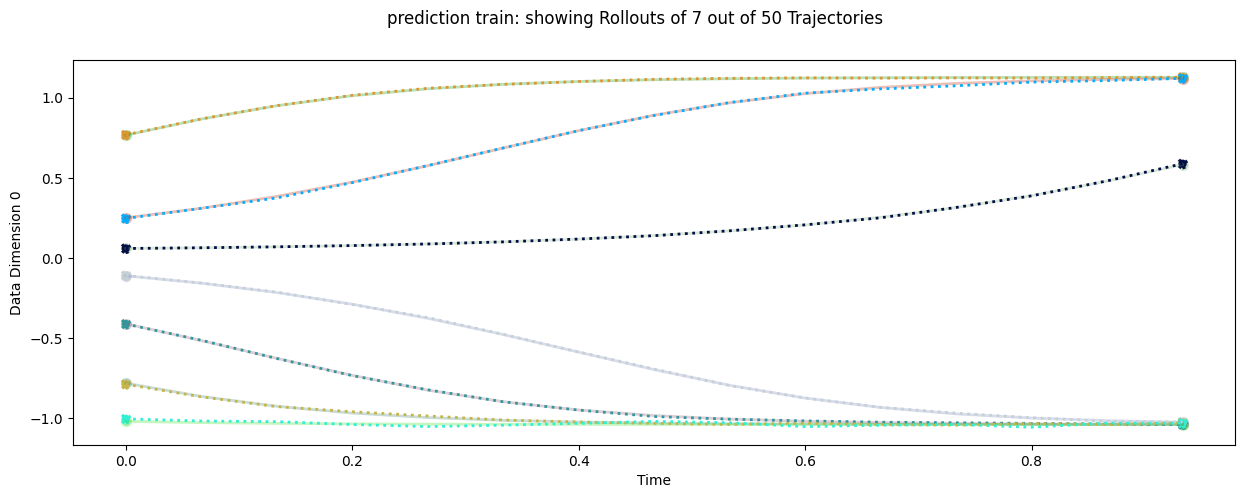

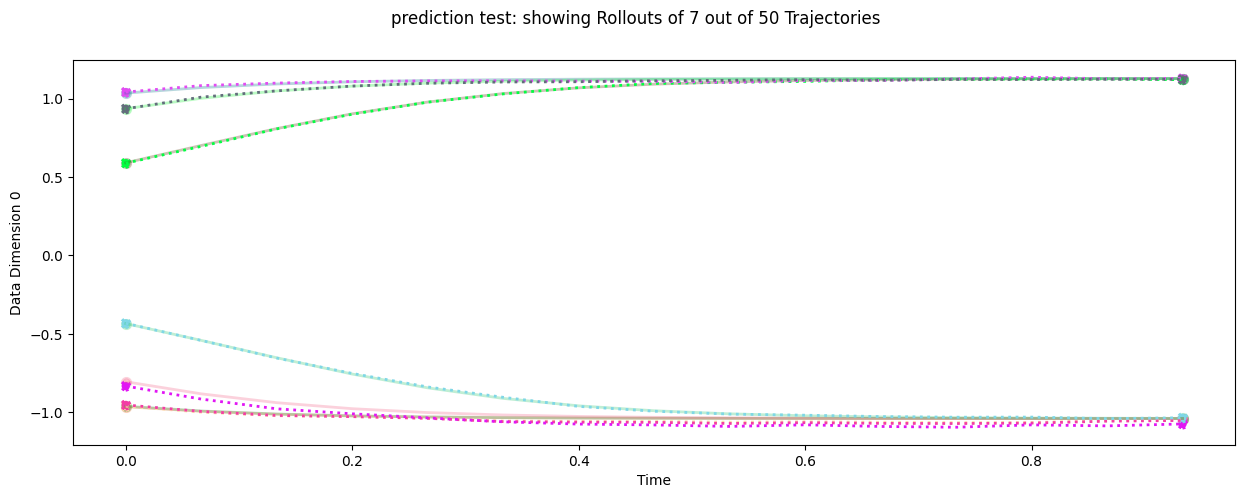

In [114]:
PRNGKey, subkey = jr.split(PRNGKey, 2)
i_plot = jr.choice(subkey, N_TRAIN, [min(7, N_TRAIN)], replace=0)
f, _ = koopcore.auxilliary.plot_data( result_best_test["data_train"]["y"], i_plot=i_plot, prepend_tag="data train", plt_params={"alpha":0.3,});
koopcore.auxilliary.plot_data( result_best_test["prediction_train"], i_plot=i_plot, prepend_tag="prediction train", fig=f,plt_params={"linestyle":"dotted",});
PRNGKey, subkey = jr.split(PRNGKey, 2)
i_plot = jr.choice(subkey, N_TEST, [min(7, N_TEST)],  replace=0)
f, _ = koopcore.auxilliary.plot_data( result_best_test["data_test"]["y"], i_plot=i_plot, prepend_tag="data test", plt_params={"alpha":0.3,});
koopcore.auxilliary.plot_data( result_best_test["prediction_test"], i_plot=i_plot, prepend_tag="prediction test", fig=f, plt_params={"linestyle":"dotted"});
print("mean train loss: {}\nmean test loss:\t {}".format(
    koopcore.auxilliary.p_norm((result_best_test["data_train"]["y"] - result_best_test["prediction_train"]).X, a=[0, 1, 2], p=2),
    koopcore.auxilliary.p_norm((result_best_test["data_test"]["y"]  - result_best_test["prediction_test"]).X,  a=[0, 1, 2], p=2)))